<a href="https://colab.research.google.com/github/gracecarrillo/Political-Data-Science/blob/master/ETL_Sentiment_Analysis_Scotref2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scottish independence: Twitter data Sentiment Analysis



## 1. Problem Statement

## 2. ETL (Extract, Load, Transform)

  - Data collection
    - Test 
    - Train

  - Preprocessing and Cleaning

    - Data Inspection
    - Data Cleaning

## 1. Problem Statement

The role of social media in shaping politics these days is hard to deny and Twitter is arguably the most studied and used source of data even though in many countries Twitter is not the main player. We use mostly Twitter data because that's what's (almost) publicly available whereas it’s (almost) impossible to collect any useful data from Facebook. As part of the IBM Advanced Data Science Specialisation, I chose to look into the current political situation in Scotland after the Brexit vote, and most recently, Boris Johnson's win the winter General Election of 2019.

Scottish voters were first asked whether they wanted Scotland to become an independent country in a referendum in September 2014; the result was 55% to 45% against independence. In its manifesto for the 2016 Scottish Parliament elections, the Scottish National Party (SNP) argued that “Scotland being taken out of the EU against our will” would justify a second vote on independence. Scotland voted by 62% to 38% in favour of Remain in the EU referendum in June 2016, and First Minister Nicola Sturgeon concluded that indyref2 “must be on the table”. In March 2017 Sturgeon formally requested the consent of Westminster to hold another referendum. But Prime Minister Theresa May declined, arguing that “now is not the time”. The first minister renewed calls for a second vote in April 2019, announcing a new process for deciding Scotland’s constitutional future. The SNP's 2019 General Election manifesto stated that the party intended to hold a second referendum in 2020; and they won 48 of Scotland’s 59 seats. So, naturally, Nicola Sturgeon has now claimed there is a “renewed, refreshed and strengthened mandate” for another vote.She has formally request the power to hold an independence referendum before the end of 2020, but it has been denied by Boris Johnson. All of this has created a complicated environment in a nation that appears to be in a very difficult (and not very favourable) position within Boris Johnson's UK.

This project looks into Twitter as political barometer for Scottish Independence using Sentiment Analysis, a Natural Language Processing subfield. I downloaded the dataset using twitter’s API. A week of Tweets were scrapped from 2020-01-08 13:49:18 to 2020-01-15 20:02:23 using keywords `indyref2`, `scottish independence` and `scotref`. The process I used to scrape the data and to analyze sentiment can be repeated for any twitter account of media page.

We train two Supervised Machine LEarning models (Support Vector Machine and Naive Bayes Classifier) and do a systematic comparison with a Deep Learning Recurrent Neural Network.

The training data was obtained from [Sentiment140](http://help.sentiment140.com/) and is made up of about 1.6 million random tweets with corresponding binary labels. 0 for Negative sentiment and 4 for Positive sentiment. 

I downloaded the test dataset using twitter’s API and will be use to test the model’s real world performance. Tweets were scrapped from 2020-01-08 13:49:18 to  2020-01-15 20:02:23 using keywords "indyref2", "scottish independence" and "scotref". Full documentation and terms of the API are available at [developer.twitter.com/en/docs](https://developer.twitter.com/en/docs).

In [0]:
# Must be upgraded
!pip install tqdm==4.36.1 --upgrade

In [0]:
!pip install tweet_parser

In [0]:
!pip install --upgrade gensim

In [0]:
!pip install vaderSentiment

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter

# tweets
import tweepy as tw
import re
from collections import Counter
from string import punctuation
from tweepy import OAuthHandler
import json

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 

# plots
from wordcloud import WordCloud
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# For geoplots
from IPython.display import IFrame
import folium
from folium import plugins
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMapWithTime
import networkx

# hide warnings
import warnings
warnings.filterwarnings("ignore")


# set plot preferences
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option("display.max_colwidth", 200) 
plt.rcParams['axes.labelcolor']='r'

print('Libraries imported')
%matplotlib inline

Libraries imported


## 2. ETL 

### 2.1 Extracting Twitter Data For Sentiment Analysis - The test data

After training the model we will make sentiment preditions on the twitter data but before we can do that, we need to download it and do some basic data pre-processing. 

I used `tweepy` which is a python wrapper library for the Twitter API that gives you more control on how you query the API.

To get a good chunk of data for the test dataset, I downloaded data using the key words `'indyref2'`, `'scottish independence'` and `'scotref'` through the API search function.

In [0]:
# Define keys
consumer_key= 'YOUR KEY'
consumer_secret= 'YOUR SECRET'
access_token= 'YOUR TOKEN'
access_token_secret= 'YOUR TOKEN SECRET'

In [0]:
# Authentication
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [0]:
# Post a tweet from Python
api.update_status("Test tweet from Python ")
# Your tweet has been posted!

In [0]:
# Define the search term and the date_since date as variables
start_time = time.time()

max_id = -1000000000000000000000000000000000
tweetsPerQry = 100  # this is the max the API permits
search_words = '(indyref2 OR "scottish independence" OR scotref)'
date_since = "2019-12-10" 

# Collect tweets
# open/create a csv file to append data
csvFile = open(search_words + '_data2.csv', 'w', encoding='utf-8')

# use csv Writer
csvWriter = csv.writer(csvFile)

# get data from twitter
tweet_num = 0
for tweet in tw.Cursor(api.search,q=search_words + ' -RT',count=tweetsPerQry,lang="en", 
                       since=date_since, max_id=str(max_id - 1)).items(9999999999):
    if tweet.place is not None:
        try:
            # not entirely necessary but you can inspect what is being written to file
            print ('tweet number: {}'.format(tweet_num), tweet.text, tweet.place.full_name)
            # write data to csv
            csvWriter.writerow([tweet.created_at,
                                tweet.user.location,
                                tweet.user.followers_count,
                                tweet.user.friends_count,
                                tweet.text,
                                tweet.place.bounding_box.coordinates,
                                tweet.place.full_name,
                                tweet.place.country,
                                tweet.place.country_code,
                                tweet.place.place_type])
            tweet_num += 1
            
        except Exception:
            pass

print("--- %s seconds ---" % (time.time() - start_time))

In [0]:
# create column names
col_names=['date','user_loc','followers','friends','message','bbox_coords',\
           'full_name','country','country_code','place_type']

# read csv
df_twtr = pd.read_csv('/content/(indyref2 OR "scottish independence" OR scotref)_data2.csv', names=col_names)

# check head
df_twtr.head()

In [0]:
# Sort dataframe by date column
df_twtr['date'] = pd.to_datetime(df_twtr['date'])
df_twtr = df_twtr.sort_values(by='date',ascending=True)
df_twtr = df_twtr.reset_index().drop('index',axis=1)
df_twtr.head()

In [0]:
# get central geo location from the bounding box for later mapping
# helper function to get mean of lats and longs
def geo_mean(x):
    y = json.loads(x)
    y = np.asarray(y)
    mean_geoloc = np.add(np.add((y[:][0][0]),(y[:][0][1]))/2,\
                         (np.add((y[:][0][2]),(y[:][0][3]))/2))/2    
    return np.around(mean_geoloc,decimals=6)

# ____________________________________________________________

# append new column  and clean up df
df_twtr['geo_code'] = df_twtr['bbox_coords'].apply(geo_mean)
df_twtr = df_twtr.drop(['bbox_coords','place_type','followers','friends'],axis=1)
df_twtr.head()

,date,user_loc,message,full_name,country,country_code,geo_code
0,2020-01-08 13:49:18,"Glasgow, Scotland",Can anyone in Scotland be arsed with this for another 5 years? Tories continue to shout down Scotland’s elected rep… https://t.co/xw8FDFOtwG,"Glasgow, Scotland",United Kingdom,GB,"[-4.241751, 55.858303]"
1,2020-01-08 13:59:26,"London, England",https://t.co/B6inPM8K8C\n\nThe Scottish Laa-Laas have IndyRef2 on their minds like they have been brainwashed by a religious cult.,"Hillingdon, London",United Kingdom,GB,"[-0.442361, 51.537061]"
2,2020-01-08 14:59:35,"Cardiff, Wales",@alcampian Scotlands best chance of independence is not any #indyref2 it's to ask the other 3 nations if they want… https://t.co/TZv4hynstr,"Cardiff, Wales",United Kingdom,GB,"[-3.1798, 51.497002]"
3,2020-01-08 15:23:24,Scotland,I’m not surprised (in the slightest) that @BorisJohnson has refused @NicolaSturgeon’s request to hold #Indyref2. Bu… https://t.co/T5yl0Ev9PD,"Glasgow, Scotland",United Kingdom,GB,"[-4.241751, 55.858303]"
4,2020-01-08 15:44:58,Scotland+,"@anninnis @BBCPolitics Vote NO to stay in the EU they said in 2014. Things change, time for IndyRef2","Glasgow, Scotland",United Kingdom,GB,"[-4.241751, 55.858303]"


In [0]:
# Save as csv
df_twtr.to_csv('/content/drive/My Drive/Twitter_Project/df_indyref2.csv')

In [0]:
# Load back in
test = pd.read_csv('/content/drive/My Drive/Twitter_Project/df_indyref2.csv')

In [0]:
test.shape

(636, 8)

This is the dataset we will use as the `test` data.

### 2.2. Training data set

In [0]:
# Load train dataset
train  = pd.read_csv('/content/drive/My Drive/Twitter_Project/training.1600000.processed.noemoticon.csv', 
                 header=None, 
                 names=['label', 'id', 'date', 'flag', 'user', 'text'],
                 encoding='latin-1')

In [0]:
train.head(3)

,label,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds


## 3. Preprocessing

Text is a highly unstructured form of data. Various types of noise are present in it and the data is not readily analysable without any pre-processing. The entire process of cleaning and standardisation of text, making it noise-free and ready for analysis is known as text preprocessing. We will divide it into 2 parts:

- Data Exploration

- Data Cleaning 


### 3.1 Data Exploration

Let's check out a few things about the `train` data:




In [0]:
train.label.value_counts()

4    800000
0    800000
Name: label, dtype: int64

Let's take a sample of the larger training data set to avoid long waiting times. 

In [0]:
train = train.copy()
train = train.sample(50000)

In [0]:
train.label.value_counts()

0    25160
4    24840
Name: label, dtype: int64

In [0]:
# check the number of positive vs. negative tagged sentences
# 0 — the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
positives = train['label'][train.label == 4]
negatives = train['label'][train.label == 0]

print('number of positve tagged sentences is:  {}'.format(len(positives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('total length of the data is:            {}'.format(train.shape[0]))

number of positve tagged sentences is:  24840
number of negative tagged sentences is: 25160
total length of the data is:            50000


Dataset has 1.6million entries, with no null entries, and importantly for the “sentiment” column, even though the dataset description mentioned neutral class, the training set has no neutral class.
50% of the data is with negative label, and another 50% with positive label.
We can see there’s no skewness on the class division.

In [0]:
# Drop unnecesary columns
# “id” column is unique ID for each tweet
# “date” column is for date info for the tweet
# “flag” column indicates whether the tweet has been collected with any particular query key word,
#    but for this column, 100% of the entries are with value “NO_QUERY”
# “user” column is the twitter handle name for the user who tweeted

train.drop(['id','date','flag','user'],axis=1,inplace=True)

In [0]:
train.head(5)

,label,text
637591,0,@whateverrr06 pringle leh!
1230332,4,yey just got in on brogÃ¥rn
965550,4,"still miserable out there. marquee from yesterdays bbq nearly flew away. philip and Anthony on Wii, gin shouting at me from cupboard"
820776,4,The day's almost over. Yay! Going outt..!
928339,4,@rustyrockets dont worry they will and for what they dont i will xx


In [9]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
train['word count'] = train['text'].apply(word_count)
train.head(3)

,label,text,word count
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",19
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,21
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,18


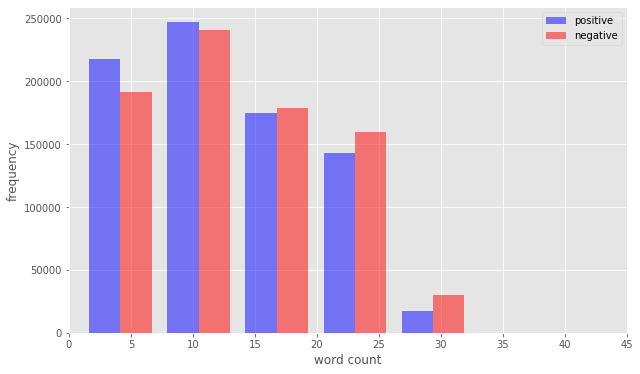

In [14]:
# plot word count distribution for both positive and negative sentiments
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option("display.max_colwidth", 200) 

x = train['word count'][train.label == 4]
y = train['word count'][train.label == 0]
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['b','r'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right');

In [12]:
# get most common words in training dataset
all_words = []
for line in list(train['text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(10)

[('i', 746635),
 ('to', 560314),
 ('the', 518734),
 ('a', 376422),
 ('my', 312846),
 ('and', 295675),
 ('you', 237766),
 ('is', 231086),
 ('for', 214051),
 ('in', 209960)]

In the cell above we extract the most common words in the dataset and list the top ten.

Perhaps to no surprise we encounter words like 'i', and and is as they are very highly used in human expressions. These kind of words usually appear equally in both negative and positive oriented expressions and as such they bring very little information that can be incorporated in the model so we will have to get rid of them down the road.

In the text preprocessing steps later on we will learn how to deal with these common words that don't add much to the feature space.

Below is a graph showing the frequency of the first 25 words.

I also created a log-log plot for the words frequency which is similar to the previous frequency graph but includes all words and is plotted on a base 10 logarithimic scale which helps us visualize the rapidly diminishing frequency of words as their rank drops.

The word distribution present in this data dictionary is a very common phenomenon in large samples of words as shown by Zipf's law where the most frequent word will occur about twice as often as the second most frequent word, three times as often as the third most frequent word, etc.
It would be intersting to see if this holds true after we remove words like i, and and is from the observation above.

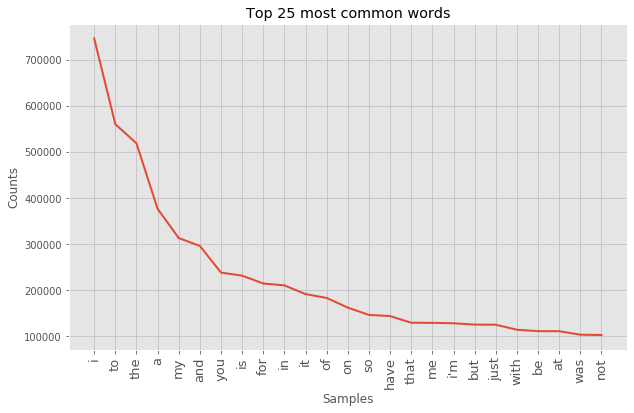

Text(0.5, 1.0, 'log-log plot of words frequency')

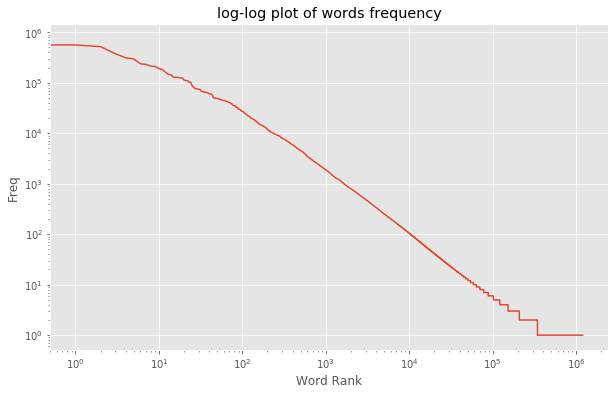

In [13]:
# plot word frequency distribution of first few words
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log plot
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency')

In [0]:
# Let’s check out a few positive/negative labelled tweets:

train[train['label'] == 0].head(10) # negative

,label,text,word count
532647,0,now doing the weights again...urgh my poor laptop is burning up in this summer evening's heat,16
715413,0,"@Ambluc, cool thanks, having trouble back replying to anyone, the little arrow is not working",15
594276,0,@angelgregzion I've never seen it. I am not much of a movie buff.,13
197250,0,"@jmlane Fanboys was viewed, and an attempt to view JCVD was made, however it was in French without subtitles",19
248996,0,It's 2am and I still can't sleep. I have class in 5 hour...,13
419778,0,wow i accidentally pressed some buttons when my phone was in the pocket and it said 321.... how weird it that?! should i be scared?,25
703692,0,"@SirMikeyB Painkillers for... erm... that thing we get that you don't lol. I miss you, everytime I sign into Skype it's so dead",23
286826,0,@jennasie crap I can't get weekends off,7
314549,0,"@mikedignammusic nooo, dont be a juggler you're voice is too nice!",11
59378,0,Cannot push the L1 button,5


In [0]:
train[train['label'] == 4].head(10) # positive

,label,text,word count
1519359,4,is it LOVE or BREAD???,5
1004219,4,just done my weekly weigh in. on target woohoo,9
1470971,4,"@LeiRock lmaoo, oh yeahh ! well im stoooopid happy",9
1439833,4,@KatyinIndy they can't help themselves,5
923795,4,just finished painting my nails a nice coral colour... I'm feeling all summery,13
825942,4,"@Clippernolan Ya, I was that girl",6
1009742,4,"@wickedmickey Sincere thanks to you. Just signing off for the evening, may your day be divine.",16
1549109,4,Save up enough money to buy my flute now. Bring on the weekend.,13
1007680,4,aww bradie and andy are in the trending topics without shaun! #shaundiviney #shaundiviney #shaundiviney #shaundiviney #shaundiviney,16
1219958,4,"@TaniliciousBabe no, she didn't reply to me =( Tanita is nice name too i'm good thanks. and u?",18


In [0]:
train.dtypes

label          int64
text          object
word count     int64
dtype: object

There are quite a many words and characters which are not really required. So, we will try to keep only those words which are important and add value.


### 3.2 Data cleaning 

In any natural language processing task, cleaning raw text data is an important step. It helps in getting rid of the unwanted words and characters which helps in obtaining better features. 

The objective of this step is to clean noise those are less relevant to find the sentiment of tweets such as punctuation, special characters, numbers, and terms which don’t carry much weightage in context to the text.

We will be following these steps below to clean the raw tweets in out data:

- We will remove HTML special entities

- We will remove the twitter handles. These twitter hardly give any information about the nature of the tweet.

- We will also get rid of the punctuations, numbers and even special characters since they wouldn’t help in differentiating different types of tweets.

- Convert the tweet to lowercase

- We will remove hyperlinks

- We will remove punctuation and split 's, 't, 've with a space for filter

- We will remove whitespace (including new line characters), and single space remaining at the front of the tweet.

- We will also remove characters beyond Basic Multilingual Plane (BMP) of Unicode

- Most of the smaller words do not add much value, so we will remove them as well.

- Lastly, we will normalize the text data. For example, reducing terms like loves, loving, and lovable to their base word, i.e., ‘love’.are often used in the same context. If we can reduce them to their root word, which is ‘love’. It will help in reducing the total number of unique words in our data without losing a significant amount of information.

In [0]:
# Pipeline like preprocessing with helper functions

nltk.download('stopwords')
stop_words = stopwords.words('english')

# cleaning helper function
def processTweet(tweet):
    """
    Takes in a string of text, then performs the following:
    1. Removes links, special characters and other bulk cleaning
    2. Returns a list of the tidy text
    """
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

# tokenize helper function
def text_process(tweet):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(tweet) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]

# Lexicon normalisation with Stemming 
def stemming(tokens):
  """
  Takes in a string of text, then performs the following:
  1. Replace words for its root based on orter Stemmer rule.
  2. Returns normalised text
   """
  stemmer = PorterStemmer()
  x = [stemmer.stem(w) for w in tokens]
   
  return ' '.join(x)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# Preprocessing
train['tidy_tweet'] = train.text.apply(processTweet)

# Double check
train['tidy_tweet'] = train.tidy_tweet.str.replace("[^a-zA-Z#]", " ") 

# tokenize tidy_tweet column and create a column for tokens
train['tokens'] = train.tidy_tweet.apply(text_process) 

#Stemming
train['tidy_tweet'] = train.tokens.apply(lambda x: stemming(x))


In [0]:
train.tidy_tweet.head(3)

1519359                                       love bread
532647     weight urgh poor laptop burn summer even heat
1004219                  done weekli weigh target woohoo
Name: tidy_tweet, dtype: object

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 1519359 to 776577
Data columns (total 5 columns):
label         50000 non-null int64
text          50000 non-null object
word count    50000 non-null int64
tidy_tweet    50000 non-null object
tokens        50000 non-null object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


You can see the difference between the raw tweets (`text`) and the cleaned tweets (`tidy_tweet`) quite clearly. Only the important words in the tweets have been retained and the noise (numbers, punctuations, and special characters) has been removed.

In [0]:
# Save cleaned dataset
train.to_csv('/content/drive/My Drive/Twitter_Project/cleaned_train_data.csv', index=False)
